In [1]:
import torch
import numpy as np
from torch import nn
import torch.nn.functional as F
from dynamics_env.dynamics_ma import Dynamics
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
file_name = 'bounded_only'

In [3]:
results_file = f'runs/Dynamics-v0__{file_name}_best_performers.csv'

In [4]:
init_params = [0.48813504, 2.15189366, 1.02763376, 2.69299098, 4.58071204, 8.75364678]
device = torch.device('cuda' if torch.cuda.is_available and False else 'cpu')
seed = 0
M = 10
orbit_timesteps = 1000
orbit_duration = 1000 # Myr

In [5]:
def make_env(seed):
        def thunk():
            env = Dynamics(hyperparameters={
                'stationary_potential_list':[],
                'stationary_potential_kwargs_list':[],
                'dynamic_potential_list':['point_source','point_source'],
                'dynamic_potential_kwargs_list':[{'M':10}, {'M':10}],
                'seed':seed,
            })
            env.action_space.seed(seed)
            env.observation_space.seed(seed)
            return env
        return thunk
env = make_env(seed=seed)()

def plot_from_init(init_params, methods=['RK45']):
    env.reset()
    _, reward, _, _, info = env.step(init_params)
    orbit = info['orbit']
    orbit_delta = info['orbit_delta']
    # init_params_delta = init_params + np.random.normal(scale=1e-8, size=len(init_params))
    fig = plt.figure(figsize=(18, 6))
    ax1 = fig.add_subplot(131, projection='3d')
    ax1.scatter(orbit.y[0][0], orbit.y[1][0], orbit.y[2][0], label='Trajectory start')
    ax1.scatter(orbit.y[6][0], orbit.y[7][0], orbit.y[8][0], label='Trajectory 2 start')
    # ax1.scatter(orbit_delta.y[0], orbit_delta.y[1], orbit_delta.y[2], label='Delta trajectory start')
    # ax1.scatter(0, 0, 0, label='Source')
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')

    ax1.plot(orbit.y[0], orbit.y[1], orbit.y[2], lw=0.5, label=r'$O$')
    ax1.plot(orbit.y[6], orbit.y[7], orbit.y[8], lw=0.5, label=r'$O_2$')
    ax1.plot(orbit_delta.y[0], orbit_delta.y[1], orbit_delta.y[2], lw=0.5, label=r'$O$')
    ax1.plot(orbit_delta.y[6], orbit_delta.y[7], orbit_delta.y[8], lw=0.5, label=r'$O_2$')
    ax2 = fig.add_subplot(132)
    
    ax2.scatter(orbit.y[0][0], orbit.y[1][0], label='Trajectory start')
    ax2.scatter(orbit.y[6][0], orbit.y[7][0], label='Trajectory 2 start')
    # ax2.scatter(0, 0, label='Source')
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_title('Projected Orbit')
    ax2.plot(orbit.y[0], orbit.y[1], lw=2, label=r'$O$')
    ax2.plot(orbit.y[6], orbit.y[7], lw=2, label=r'$O_2$')
    ax2.plot(orbit_delta.y[0], orbit_delta.y[1], lw=2, label=r'$O$')
    ax2.plot(orbit_delta.y[6], orbit_delta.y[7], lw=2, label=r'$O_2$')
    # ax3 = fig.add_subplot(133)
    # ax3.set_xlabel('logdist')
    # ax3.set_ylabel('t')
    # ax3.set_title(f'Logdists')
    ax1.set_title(f'3D Orbit')
    # for method in methods:
    #     orbit_delta = solve_ivp(get_equations, t_span=(0, orbit_duration), y0=init_params_delta, t_eval=np.linspace(0, orbit_duration, orbit_timesteps),method=method)
    #     orbit_dists = np.linalg.norm(orbit.y - orbit_delta.y, axis=0)
    #     log_orbit_dists = np.log(orbit_dists + 1e-8)
    #     fit_coeffs = np.polyfit(orbit.t, log_orbit_dists, 1)
    #     max_r = np.max(np.linalg.norm(orbit.y[:3], axis=0))
    #     damping = out_of_bounds_damping(max_r)
    #     reward = fit_coeffs[0] * damping
        
    #     ax1.plot(orbit_delta.y[0], orbit_delta.y[1], orbit_delta.y[2], lw=0.5, label=r'$O+\delta O$ %s %.3f'%(method, reward))
    #     ax2.plot(orbit_delta.y[0], orbit_delta.y[1], lw=2, label=r'$O+\delta O$ %s'%method)
    #     ax3.plot(log_orbit_dists[:], lw=2, label=r'log$(\Delta X)$ %s'%method)
    #     X_fit = np.linspace(orbit.t[0], orbit.t[-1], 100)
    #     Y_fit = fit_coeffs[0] * X_fit + fit_coeffs[1]
    #     ax3.plot(X_fit, Y_fit, lw=2, label=r'Fit line %s'%method)
        
    print(reward)
    print(init_params)
    ax1.legend()
    ax2.legend()
    # ax3.legend()

[ENV] Using cpu
[ENV] Seed set to 0


Text(0, 0.5, 'Y')

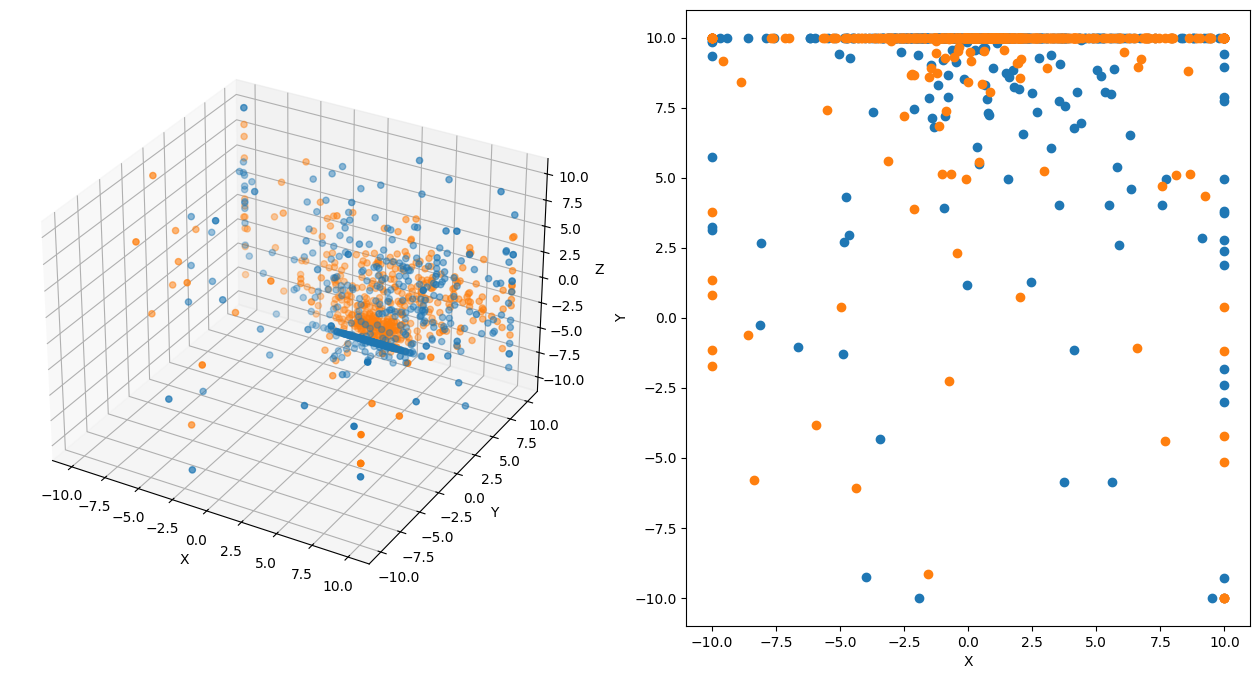

In [6]:
results = pd.read_csv(results_file).sort_values(by=['reward'], ascending=False)
result_init_params = {i:results.iloc[:, [j for j in range(i * 6+1, (i+1) * 6 + 1)]].to_numpy().transpose() for i in range(env.num_agents)}
result_init_params['reward'] = results.loc[:,'reward'].to_numpy()
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(121, projection='3d')
for agent in range(env.num_agents):
    ax1.scatter(result_init_params[agent][0], result_init_params[agent][1], result_init_params[agent][2])
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
# ax1.legend()

ax2 = fig.add_subplot(122)
for agent in range(env.num_agents):
    ax2.scatter(result_init_params[agent][0], result_init_params[agent][1])
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
# ax2.legend()

In [7]:
def result_to_init(i):
    return {agent:(result_init_params[agent][:,i]) / env.high for agent in range(env.num_agents)}

{0: np.float64(0.012124845656198636), 1: np.float64(0.016253085738609306)}
{0: array([ 1.        ,  0.78663201,  1.        , -0.0250167 , -0.03553765,
       -0.01780073]), 1: array([ 1.        , -1.        , -0.35893245, -0.01759754, -0.04002254,
       -0.01601464])}


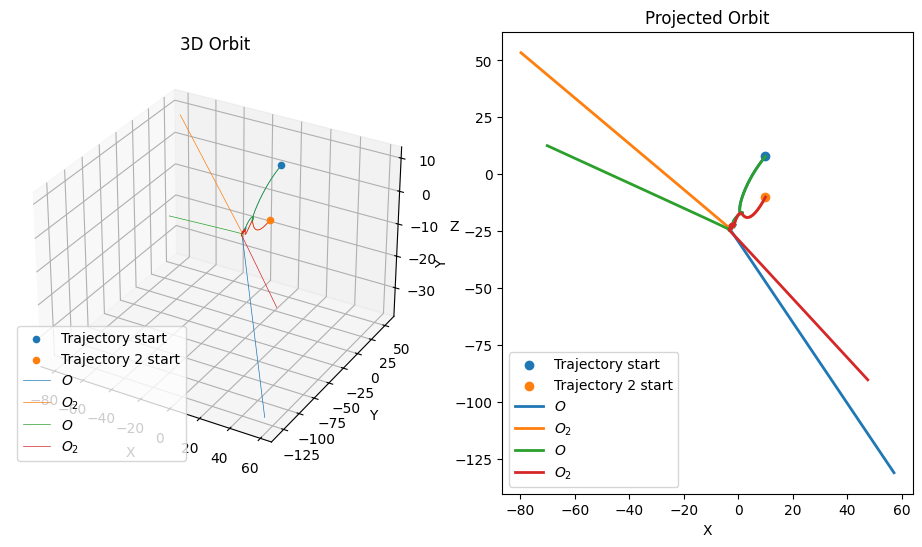

In [8]:
plot_from_init(result_to_init(0))

{0: np.float64(0.007434784752785354), 1: np.float64(0.01090285058528412)}
{0: array([ 0.01812819,  1.        , -1.        , -0.06051392,  0.00522265,
       -0.14866236]), 1: array([ 0.08873521,  1.        , -0.79893341, -0.02075766, -0.06060879,
        0.1024318 ])}


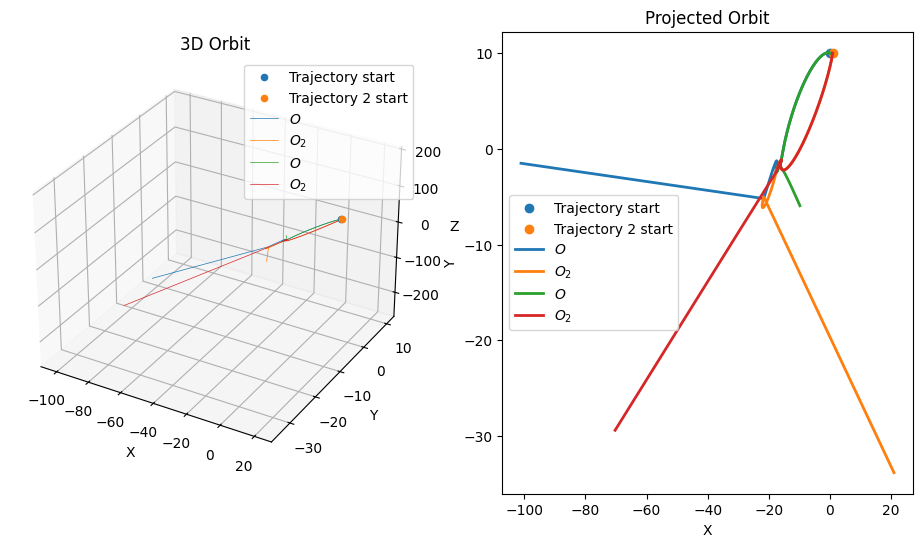

In [9]:
plot_from_init(result_to_init(1))

{0: np.float64(0.016064568584195655), 1: np.float64(0.014353631080988376)}
{0: array([-1.        ,  1.        ,  0.06811851, -0.00698979,  0.01947605,
       -0.04283879]), 1: array([-0.11479461,  0.68326278,  0.43652124,  0.05997225,  0.0021436 ,
       -0.00152559])}


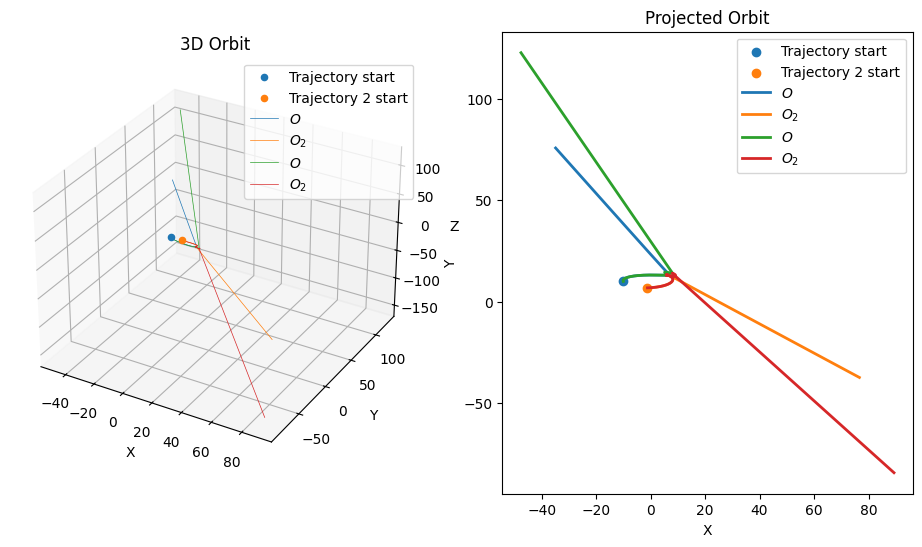

In [10]:
plot_from_init(result_to_init(5))

{0: np.float64(0.0001445318494482194), 1: np.float64(0.00014694059396415146)}
{0: array([0.70710678, 0.        , 0.        , 0.        , 0.01      ,
       0.        ]), 1: array([ 0.  ,  0.  ,  0.  ,  0.  , -0.01,  0.  ])}


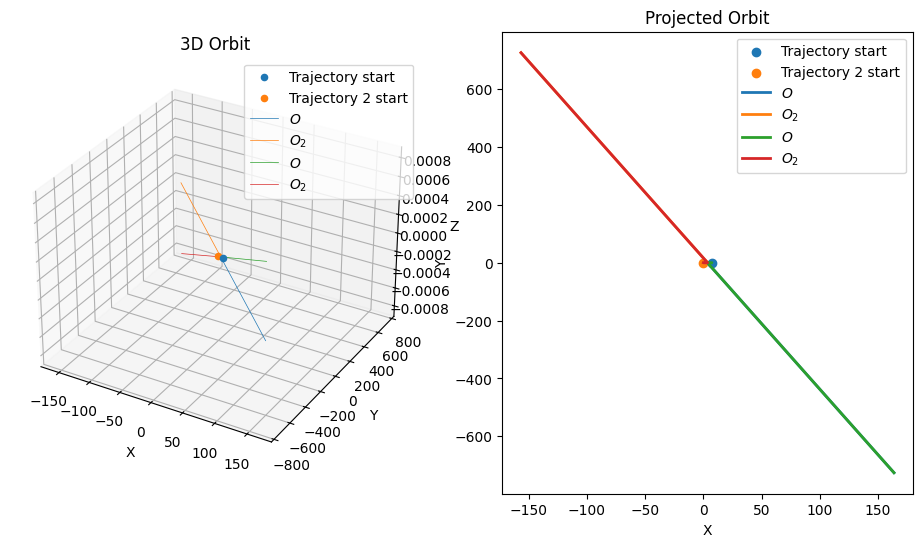

In [11]:
init_params = {0: np.array([np.sqrt(2)*0.5, 0, 0, 0, 0.01, 0]), 1: np.array([0, 0, 0, 0, -0.01, 0])}
plot_from_init(init_params)

In [12]:
kk

NameError: name 'kk' is not defined

{0: np.float64(0.008533077375850191), 1: np.float64(0.00892958580668745)}


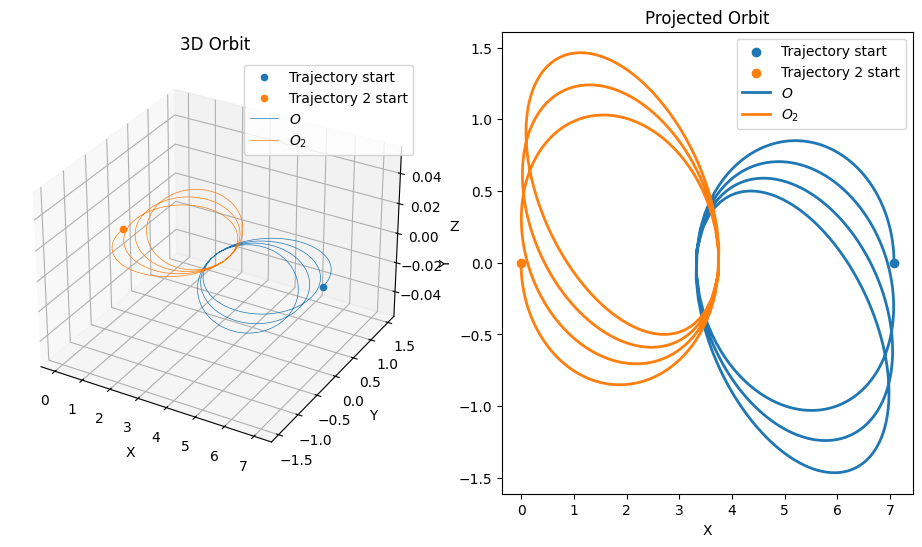

In [ ]:
init_params = {0: np.array([np.sqrt(2)*0.5, 0, 0, 0, 0.01, 0]), 1: np.array([0, 0, 0, 0, -0.01, 0])}
plot_from_init(init_params)

In [ ]:
plot_from_init(rewards_params_list[2*plot_frac][1], methods)

NameError: name 'rewards_params_list' is not defined

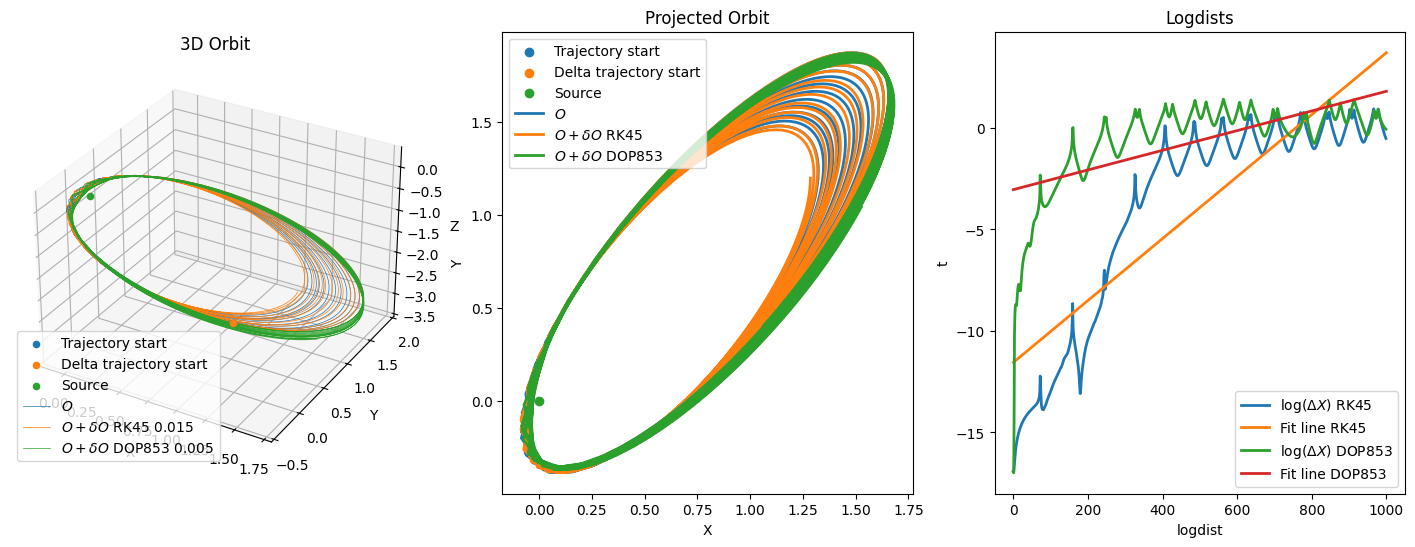

In [ ]:
plot_from_init(rewards_params_list[3*plot_frac][1], methods)

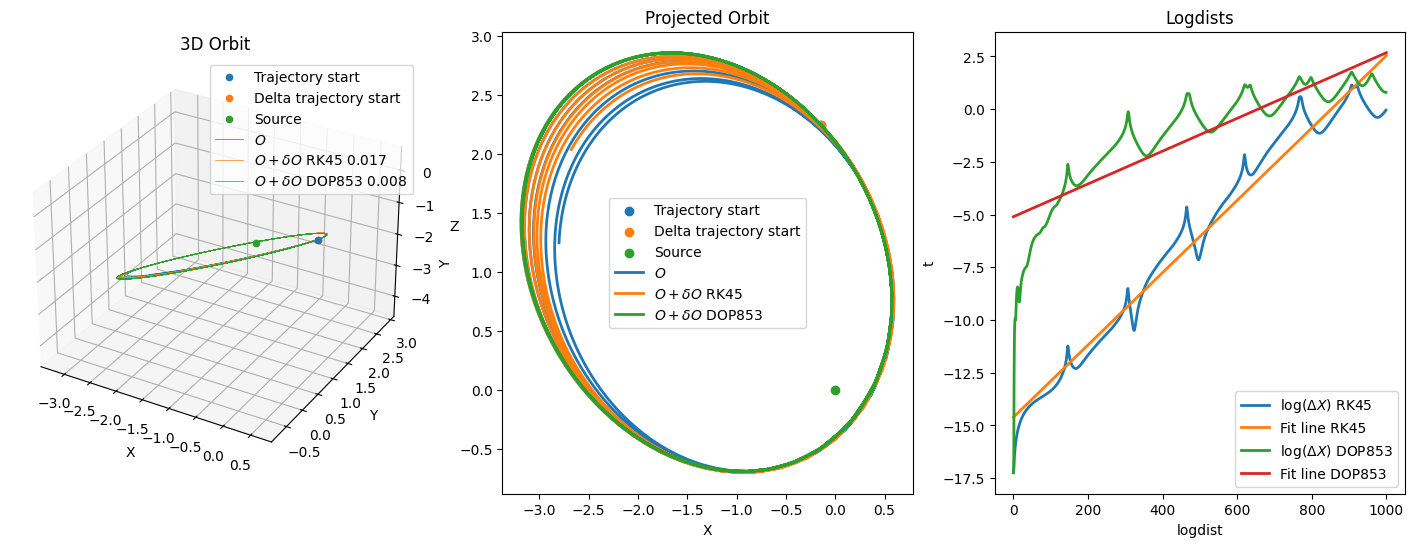

In [ ]:
plot_from_init(rewards_params_list[4*plot_frac][1], methods)

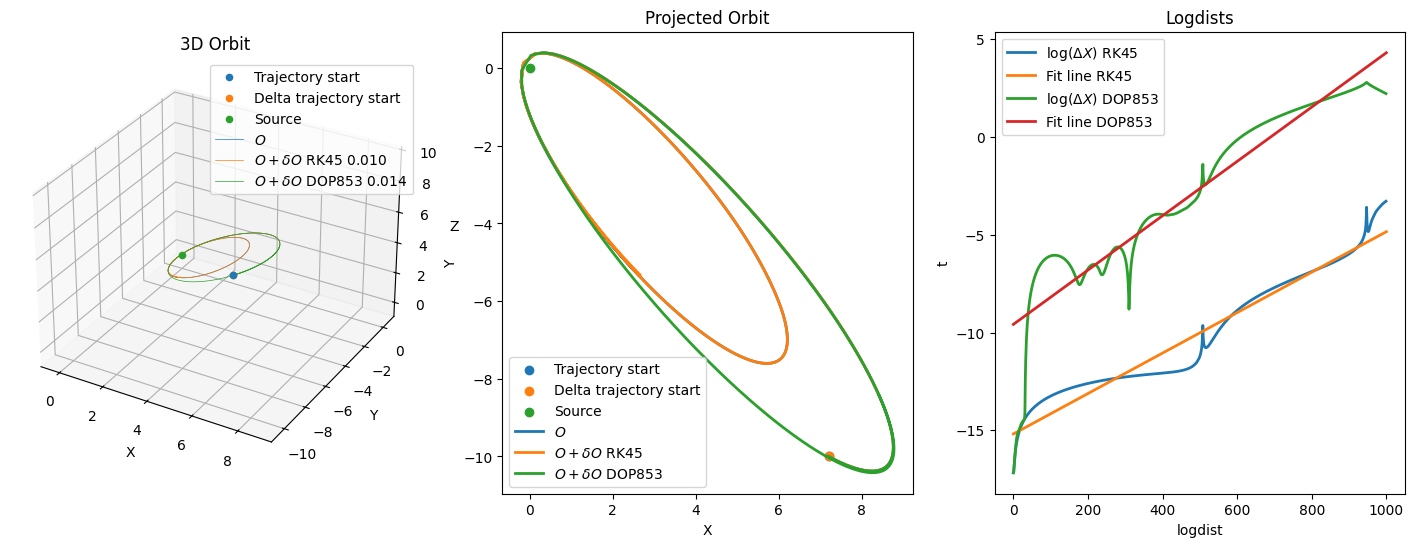

In [ ]:
plot_from_init(rewards_params_list[5*plot_frac-1][1], methods)

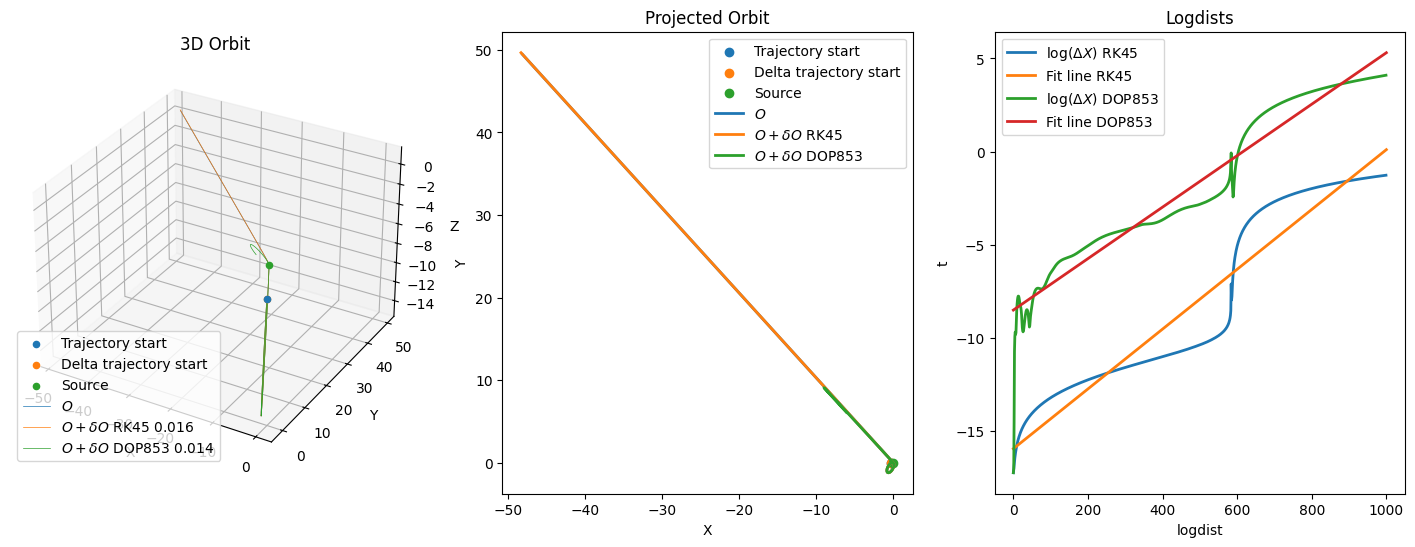

In [ ]:
plot_from_init(rewards_params_list[-1][1], methods)

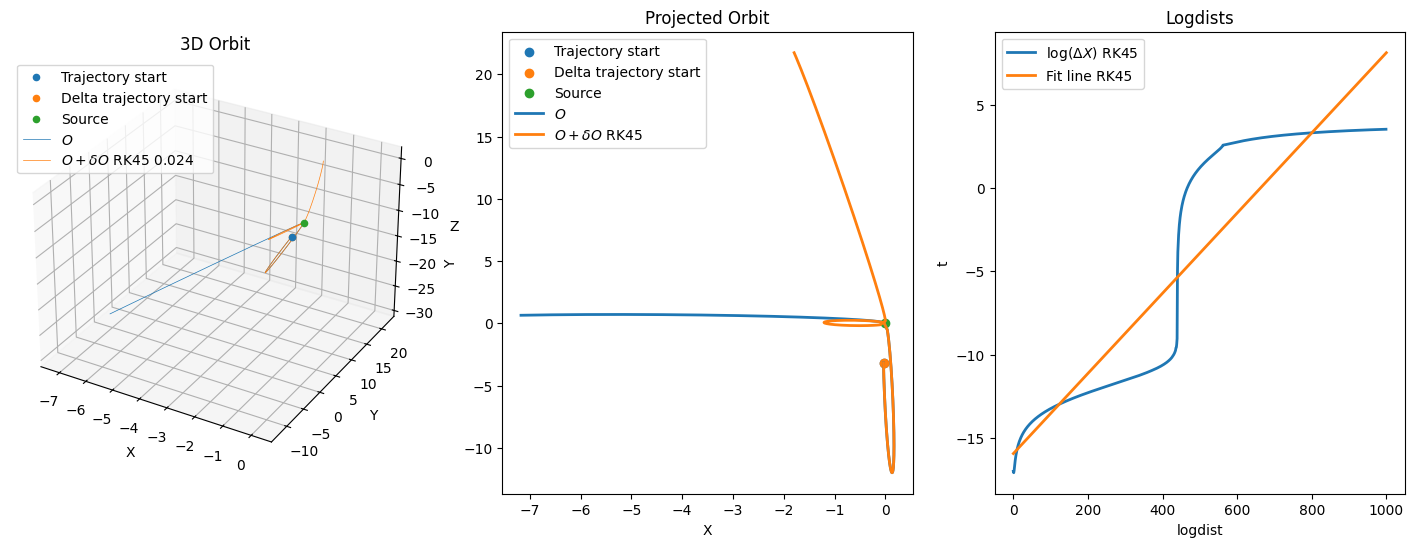

In [ ]:
plot_from_init([-0.0365058034658432, -3.160510540008545, -0.8251099586486816, 0.0005327022518031299, -0.13614143431186676, -0.026966970413923264])